#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [254]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [255]:
path = '/content/drive/MyDrive/project_dl/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [257]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [258]:
data = pd.read_csv(path + 'data01_train.csv')
new_data = pd.read_csv(path +'data01_test.csv')

In [259]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [260]:
data['Activity_dynamic'] = data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)
#new_data['Activity_dynamic'] = new_data['Activity'].apply(lambda x: 1 if x in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'] else 0)

In [261]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Activity_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1


In [262]:
data.drop('subject', axis=1, inplace=True)
new_data.drop('subject', axis=1, inplace=True)

In [263]:
data_dyn = data[data['Activity_dynamic'] == 1]
data_sta = data[data['Activity_dynamic'] == 0]

In [264]:
# 동적/정적 이진 분류

X_bi = data.drop(['Activity','Activity_dynamic'], axis=1)
y_bi = data['Activity_dynamic']

X_bi_train, X_bi_valid, y_bi_train, y_bi_valid = train_test_split(X_bi, y_bi, test_size=.3, stratify=y_bi, random_state=42)

In [265]:
# 동적 행동 다중 분류
X_dyn = data_dyn.drop(['Activity', 'Activity_dynamic'], axis=1)
y_dyn = data_dyn['Activity']

dyn_l_enc = LabelEncoder()
y_dyn = dyn_l_enc.fit_transform(y_dyn)

X_dyn_train, X_dyn_valid, y_dyn_train, y_dyn_valid = train_test_split(X_dyn, y_dyn, test_size=.3, stratify=y_dyn,random_state=42)

In [266]:
# 정적 행동 다중 분류
X_sta = data_sta.drop(['Activity', 'Activity_dynamic'], axis=1)
y_sta = data_sta['Activity']

sta_l_enc = LabelEncoder()
y_sta = sta_l_enc.fit_transform(y_sta)

X_sta_train, X_sta_valid, y_sta_train, y_sta_valid = train_test_split(X_sta, y_sta, test_size=.3, stratify=y_sta, random_state=42)

#### 2) 기본 정보 조회

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

### (2) x, y 분리

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

### (4) 데이터 분할
* train, val 분할

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [267]:
# 모델 정의
clear_session()
def binary_dnn(n_input):
    model = Sequential()
    model.add(Dense(256, input_dim=n_input, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate= 0.001),
                  loss='binary_crossentropy')
    return model

binary_dnn_model = binary_dnn(X_bi_train.shape[1])
binary_dnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         143,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,089 (723.00 KB)

 Trainable params: 185,089 (723.00 KB)

 Non-trainable params: 0 (0.00 B)

In [268]:
es = EarlyStopping(monitor = 'val_loss', patience = 20)

binary_hist = binary_dnn_model.fit(X_bi_train, y_bi_train,
                                   epochs=150, validation_split=.2, verbose=0,
                                   callbacks = [es]).history

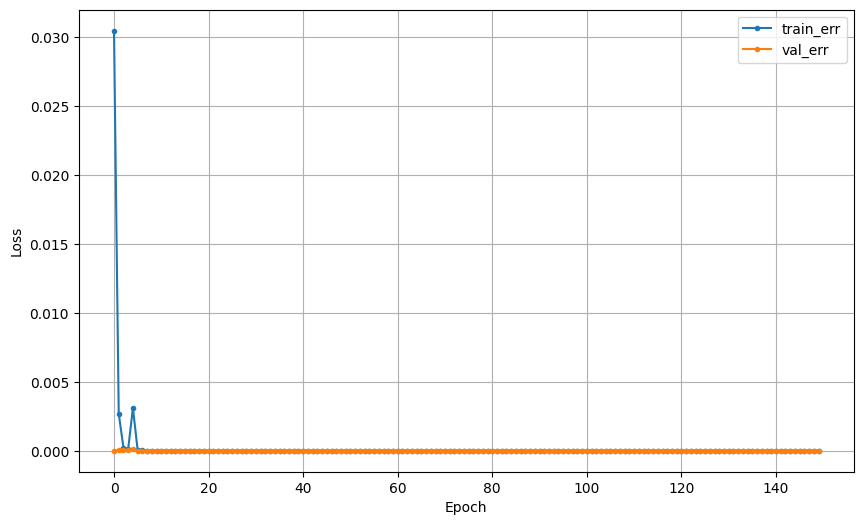

In [269]:
dl_history_plot(binary_dnn_model.history.history)

In [270]:
binary_valid_pred = binary_dnn_model.predict(X_bi_valid)
binary_valid_pred = np.where(binary_valid_pred >= 0.5, 1, 0)
#평가
print('accuracy :',accuracy_score(y_bi_valid, binary_valid_pred))
print('='*60)
print(confusion_matrix(y_bi_valid, binary_valid_pred))
print('='*60)
print(classification_report(y_bi_valid, binary_valid_pred))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
accuracy : 1.0
[[971   0]
 [  0 794]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       971
           1       1.00      1.00      1.00       794

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 2) 모델2

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [319]:
# 모델 정의
clear_session()
def static_dnn(n):
    model = Sequential([
        Input(shape=(n,)),
        Dense(196,activation = 'relu'),
        Dropout(0.2),
        Dense(96,activation = 'relu'),
        Dropout(0.2),
        Dense(48,activation = 'relu'),
        Dense(24,activation = 'relu'),
        Dense(12,activation = 'relu'),
        Dense(6,activation = 'relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy')
    return model

static_dnn_model = static_dnn(X_sta_train.shape[1])
static_dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 196)                 │         110,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 196)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 96)                  │          18,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 24)                  │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │              78 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 135,295 (528.50 KB)

 Trainable params: 135,295 (528.50 KB)

 Non-trainable params: 0 (0.00 B)

In [320]:

static_hist = static_dnn_model.fit(X_sta_train, y_sta_train,
                                   epochs=130, validation_split=.2, verbose=0).history

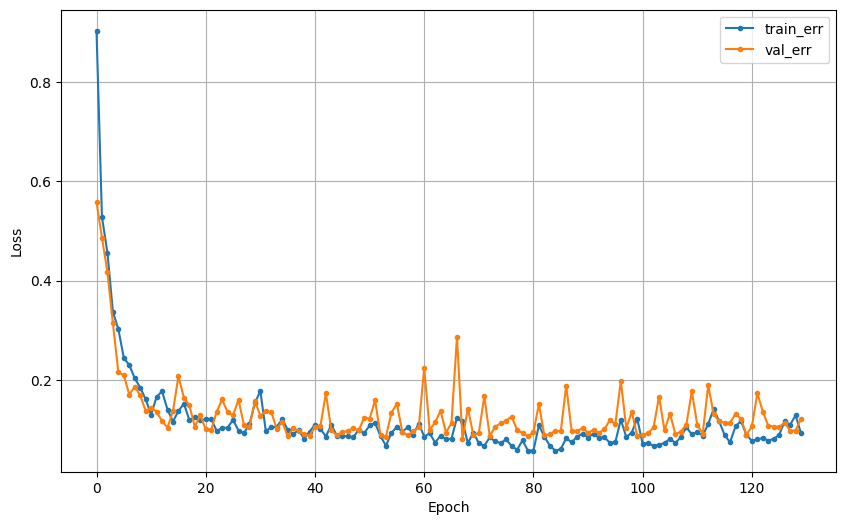

In [321]:
dl_history_plot(static_hist)

In [322]:
static_valid_pred = static_dnn_model.predict(X_sta_valid)
static_valid_pred = static_valid_pred.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_sta_valid, static_valid_pred))
print('='*60)
print(confusion_matrix(y_sta_valid, static_valid_pred))
print('='*60)
print(classification_report(y_sta_valid, static_valid_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
accuracy : 0.964984552008239
[[335   0   0]
 [  0 305   5]
 [  0  29 297]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       0.91      0.98      0.95       310
           2       0.98      0.91      0.95       326

    accuracy                           0.96       971
   macro avg       0.97      0.96      0.96       971
weighted avg       0.97      0.96      0.96       971



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [295]:
# 모델 정의
clear_session()
def dynamic_dnn(n_input):
    model = Sequential([
        Input(shape=(n_input,)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(16, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy')
    return model

dynamic_dnn_model = dynamic_dnn(X_dyn_train.shape[1])
dynamic_dnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         143,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,115 (727.01 KB)

 Trainable params: 186,115 (727.01 KB)

 Non-trainable params: 0 (0.00 B)

In [296]:
es = EarlyStopping(monitor = 'val_loss', patience = 30)

dynamic_hist = dynamic_dnn_model.fit(X_dyn_train, y_dyn_train,
                                   epochs=200, validation_split=.2, verbose=0,
                                   callbacks = [es]).history

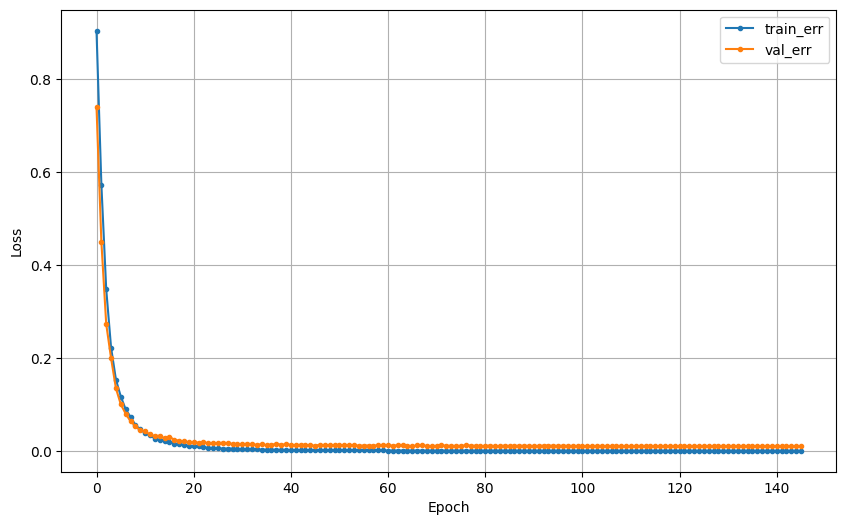

In [297]:
dl_history_plot(dynamic_hist)

In [298]:
dynamic_valid_pred = dynamic_dnn_model.predict(X_dyn_valid)
dynamic_valid_pred = dynamic_valid_pred.argmax(axis=1)

#평가
print('accuracy :',accuracy_score(y_dyn_valid, dynamic_valid_pred))
print('='*60)
print(confusion_matrix(y_dyn_valid, dynamic_valid_pred))
print('='*60)
print(classification_report(y_dyn_valid, dynamic_valid_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
accuracy : 0.9924528301886792
[[299   0   1]
 [  2 234   1]
 [  2   0 256]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       300
           1       1.00      0.99      0.99       237
           2       0.99      0.99      0.99       258

    accuracy                           0.99       795
   macro avg       0.99      0.99      0.99       795
weighted avg       0.99      0.99      0.99       795



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [299]:
import joblib
def har_predict_pipeline(new_data, binary_model, dynamic_model, static_model):
    # 평가 데이터셋에서 X와 y분리
    X = new_data.drop('Activity',axis=1)

    y_test = new_data['Activity']
    test_l_enc = LabelEncoder()
    y_test = test_l_enc.fit_transform(y_test)

    dynamic_pred = binary_model.predict(X) > 0.5
    final_preds = np.zeros((X.shape[0],))

    # 동적 행동 데이터에 대한 인덱스
    dynamic_indices = np.where(dynamic_pred.flatten() == True)[0]
    # 정적 행동 데이터에 대한 인덱스
    static_indices = np.where(dynamic_pred.flatten() == False)[0]

    if len(dynamic_indices) > 0:
        dynamic_activities_pred = dynamic_model.predict(X.iloc[dynamic_indices])
        dynamic_activities_pred = np.argmax(dynamic_activities_pred, axis=1)
        dynamic_activities_pred += 3
        final_preds[dynamic_indices] = dynamic_activities_pred

    if len(static_indices) > 0:
        static_activities_pred = static_model.predict(X.iloc[static_indices])
        static_activities_pred = np.argmax(static_activities_pred, axis=1)
        final_preds[static_indices] = static_activities_pred


    # final_preds와 실제 라벨 y_test를 비교하여 정확도 계산
    accuracy = accuracy_score(y_test, final_preds)
    print(f'Accuracy: {accuracy:.4f}')

    # 행렬
    cm = confusion_matrix(y_test, final_preds)
    class_names = test_l_enc.classes_

    # 시각화
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # 모델 저장
    joblib.dump(binary_model, path + 'binary_model.pkl')
    joblib.dump(dynamic_model, path + 'dynamic_model.pkl')
    joblib.dump(static_model, path + 'static_model.pkl')

    return final_preds

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.9674


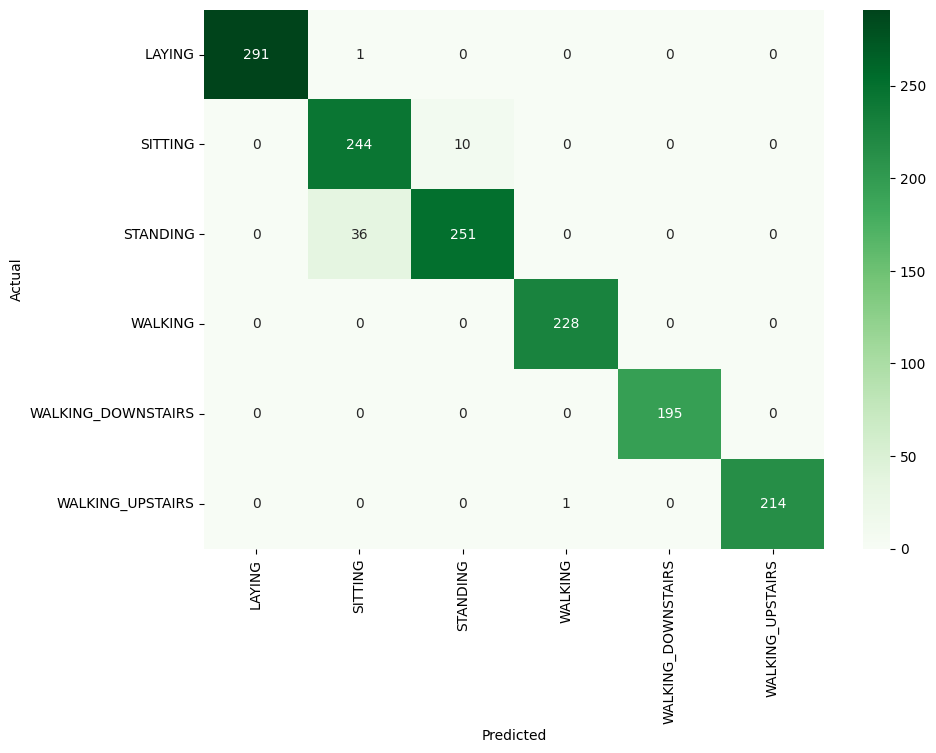

In [323]:
har_predict = har_predict_pipeline(new_data, binary_dnn_model, dynamic_dnn_model, static_dnn_model)

#### 2) test 셋으로 예측하고 평가하기